# 1.) Import an asset price from Yahoo Finance

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("SBUX", start="1990-01-01", end="2022-02-21")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]


[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [3]:
x_train = []
y_train = []


#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 10
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(1 if train_data[i, 0] > 0 else 0) # IF Y_TRAIN > 0:1 ELSE 0


x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# y_train = y_train.reshape(y_train.shape[0],1)

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], activation='sigmoid', return_sequences=True, input_shape=(x_train.shape[1], 1)))
#Examples
model.add(LSTM(10, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

# Classification algo maybe unit(pick your activation function)


model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=3, epochs=10)

Epoch 1/10
1988/1988 [==============================] - 20s 8ms/step - loss: 0.2504
Epoch 2/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2504
Epoch 3/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2501
Epoch 4/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2502
Epoch 5/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2500
Epoch 6/10
1988/1988 [==============================] - 12s 6ms/step - loss: 0.2500
Epoch 7/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2501
Epoch 8/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2500
Epoch 9/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2501
Epoch 10/10
1988/1988 [==============================] - 10s 5ms/step - loss: 0.2501


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [4]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
# y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test = []


for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])
    y_test.append(1 if test_data[i, 0] > 0 else 0)

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




pred_test = model.predict(x_test)
pred_test = pred_test[:,0]
pred_train = model.predict(x_train)
pred_train = pred_train[:,0]

187/187 [==============================] - 0s 2ms/step


In [5]:
pred_test = np.where(pred_test > 0.5, 1, 0)
pred_train = np.where(pred_train > 0.5, 1, 0)

In [6]:
from sklearn.metrics import accuracy_score
import random

In [7]:
rw_train = []
rw_test = []
rd = [0, 1]
for i in range(len(pred_train)):
  rw_train.append(random.choice(rd))
for i in range(len(pred_test)):
  rw_test.append(random.choice(rd))

In [8]:
# IN SAMPLE Random Walk accuracy
a = accuracy_score(y_train, rw_train)
print("IN SAMPLE Random Walk accuracy: ", accuracy_score(y_train, rw_train))
# IN SAMPLE Model accuracy
b = accuracy_score(y_train, pred_train)
print("IN SAMPLE Model accuracy: ", accuracy_score(y_train, pred_train))

print("")

# OOS Random Walk accuracy
c = accuracy_score(y_test, rw_test)
print("OOS Random Walk accuracy: ", accuracy_score(y_test, rw_test))
# OOS Model accuracy
d = accuracy_score(y_test, pred_test)
print("OOS Model accuracy: ", accuracy_score(y_test, pred_test))

IN SAMPLE Random Walk accuracy:  0.4988262910798122
IN SAMPLE Model accuracy:  0.5098926894701542

OOS Random Walk accuracy:  0.4919678714859438
OOS Model accuracy:  0.4879518072289157


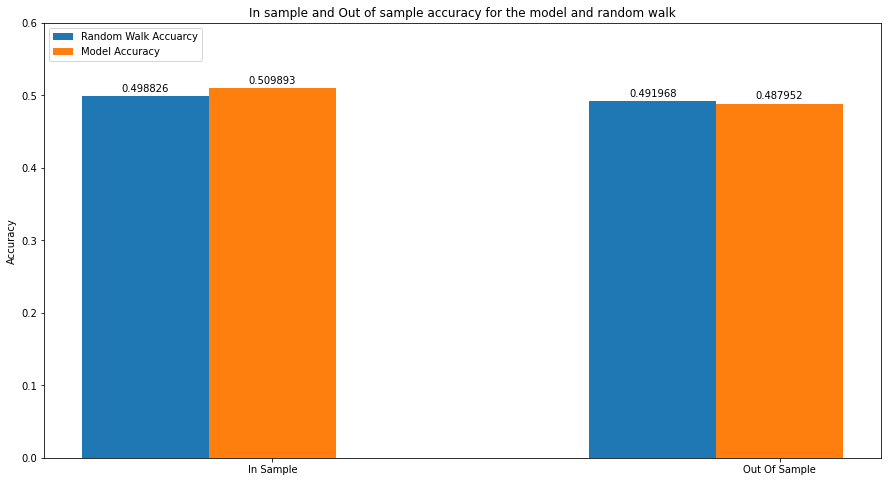

In [9]:
import matplotlib.pyplot as plt

species = ("In Sample", "Out Of Sample")
penguin_means = {
    'Random Walk Accuarcy': (a, c),
    'Model Accuracy': (b, d)
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(15,8))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy')
ax.set_title('In sample and Out of sample accuracy for the model and random walk')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left')
ax.set_ylim(0, 0.60)
# plt.grid()
plt.show()

# DONT DO 4.) Plot in and out of sample accuracy

In [10]:
# import matplotlib.pyplot as plt

# # Make predictions on full dataset

# test_predict = model.predict(x_test)
# test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

# train_predict = model.predict(x_train)
# train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



# plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
# plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
# end_val = np.cumprod(y_train+1)[-1]
# test_predict = model.predict(x_test)
# test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
# plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
# plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
# plt.xlabel("Date")
# plt.ylabel("Stock Price")
# plt.legend()
# plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

In [16]:
# Q4 will be misleading. And from Q3 we can see that our 
# RNN model can't outperform the random walk model both in and out of sample when the lag is 10 days.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [12]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# x_train = []
# y_train = []


# Define the Keras model
###Edit here to create your optimizer
def create_model(lags): # Add a parameter

    # global x_train
    # global y_train
    # x_train = []
    # y_train = []
    # input_size = lags
    # for i in range(input_size, len(train_data)):
    #     x_train.append(train_data[i-input_size:i, 0])
    #     y_train.append(1 if train_data[i, 0] > 0 else 0) # IF Y_TRAIN > 0:1 ELSE 0
    # x_train, y_train = np.array(x_train), np.array(y_train)
    # x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    # print(131231)
    model = Sequential()
    model.add(LSTM(10, input_shape=(lags,1), activation='sigmoid')) #Change the input_dim
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # print(99999)
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
param_grid = {
            #  'batch_size': [10, 20, 100],
             'batch_size': [10],
             'epochs': [1],
             'lags': [5,10,20]
            #  'neuron':[5,10,20]}
             }

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# print(grid)
grid_result = grid.fit(x_train, y_train)
# print(grid)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-12-0bce8ade87ca>:32: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
6 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/d

Best: -0.695135 using {'batch_size': 10, 'epochs': 1, 'lags': 10}


In [13]:
# global x_train
# global y_train
# x_train = []
# y_train = []
# input_size = 10
# for i in range(input_size, len(train_data)):
#     x_train.append(train_data[i-input_size:i, 0])
#     y_train.append(1 if train_data[i, 0] > 0 else 0) # IF Y_TRAIN > 0:1 ELSE 0
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))